[In English](../use-case_oafeat-interactive_en/)

![ECCC logo](https://eccc-msc.github.io/open-data/img_eccc-logo.png)  

[TdM](../../../readme_fr/) > [Aperçu de l'utilisation](../../readme_fr/) > Requêtes OGC API - Features avec Python (version interactive)

# Cas d'utilisation: Récupération et affichage de données hydrométriques

## Introduction

Les données hydrométriques du Service météorologique du Canada (SMC) d'Environnement et Changement climatique Canada (ECCC) peuvent être facilement accédées via [GeoMet-OGC-API](https://api.weather.gc.ca/). Les services web [OGC API - Features](https://eccc-msc.github.io/open-data/msc-geomet/web-services_fr/#ogc-api-features) disponibles dans GeoMet-OGC-API permettent d'effectuer des requêtes de données géospatiales vectorielles et de récupérer ces données en format GeoJSON. Les fichiers GeoJSON peuvent ensuite être utilisés directement pour réaliser des analyses et afficher les données sur des cartes ou peuvent être soumis à des étapes supplémentaires de traitement de données. Ce cas d'utilisation démontre comment: 
* Effectuer des requêtes et récupérer des données géospatiales vectorielles disponibles dans GeoMet-OGC-API à l'aide de [Python](https://www.python.org/)
* Afficher des données de séries temporelles en format graphique et tabulaire
* Créer une carte interactive présentant les données géospatiales récupérées

Ce cas d'utilisation est disponible en deux versions. Cette version-ci a été concue spécifiquement pour Jupyter Notebook et tire avantage du niveau supérieur d'interactivité offert par cette application. Elle comprend entre autres des menus déroulants pour sélectionner la valeur de certaines variables, un graphique interactif comportant une plus grande variété de fonctions et une carte interactive basée sur Leaflet. Comme certaines bibliothèques de programmation utilisées dans cette version telles que ipywidgets ne sont pas conçues pour être utilisées hors de Jupyter Notebook, [une autre version de ce cas d'utilisation](../use-case_oafeat-script_fr/) présente un script qui est adapté pour être exécuté directement dans un terminal ou dans un environnement de développement intégré.

Pour exécuter l'entièreté de ce carnet, cliquez sur le symbole ⏩️ ou sélectionnez l'option *Cell* -> *Run All* dans la barre de menu.

[![badge](https://img.shields.io/badge/Version%20interactive-binder-F5A252.svg?logo=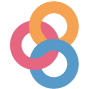)](https://mybinder.org/v2/gh/flaframboise/open-data.git/ME_notebook_corrections?labpath=docs%2Fusage%2Fuse-case_oafeat%2Fuse-case_oafeat-interactive_fr.ipynb)

## Création d'un outil pour suivre l'évolution des niveaux d'eau 

Cathy dirige une compagnie d'excursions en bateau et de sports nautiques à Chilliwack en Colombie-Britannique. Elle aimerait suivre le niveau d'eau de certaines stations hydrométriques situés près de Chilliwack afin de guider la gestion des activités de sa compagnie. Elle aimerait obtenir:
* Les moyennes journalières de niveau d'eau pour une période de trois mois pour toutes les stations hydrométriques situées dans un rayon de 100 km de Chilliwack
* Une vue graphique et tabulaire des moyennes journalières de niveau d'eau de cette période
* Une carte interactive présentant les stations hydrométriques situées dans un rayon de 100 km de Chilliwack et la moyenne journalière de niveau d'eau la plus récente de ces stations pour la période temporelle sélectionnée

Pour y arriver, la première étape est d'importer les modules Python nécessaires et de sélectionner les paramètres de requête désirés.

In [1]:
# Importation des modules
from datetime import date
import json

from ipyleaflet import (
    AwesomeIcon,
    basemaps,
    FullScreenControl,
    Map,
    Marker,
    ScaleControl,
    WidgetControl,
)
from ipywidgets import HTML, interact
from osgeo import ogr, osr
from owslib.ogcapi.features import Features
import numpy as np
import pandas as pd

In [2]:
# Paramètres

# Coordonnées de Chilliwack
lat = 49.162676
long = -121.958943

# Taille de la zone tampon en kilomètres
buffer = 100

# Dates de début et de fin de la période temporelle pour
# laquelle des données seront récupérées
start_date = date(2018, 6, 1)
end_date = date(2018, 8, 31)

# Code ESPG de la projection désirée pour crééer la zone tampon
# NAD83 / Statistiques Canada Lambert
projection = 3347

In [3]:
# Formattage des paramètres pour la requête OGC API - Features

# Zone de délimitation légèrement plus grande que la taille de la zone tampon

# La taille de la zone tampon doit être transformée en degrés afin d'obtenir
# les coordonnées des coins de la zone de délimitation:
# Latitude: 1 km ≈ 0.009° 
# Longitude (au 49e parallèle): 1 km ≈ 0.014°
bbox = [
    long - buffer * 0.02,
    lat - buffer * 0.01,
    long + buffer * 0.02,
    lat + buffer * 0.01,
]

# Formattage de la période temporelle sélectionnée
time_ = f"{start_date}/{end_date}"

Ensuite, les [données des stations hydrométriques](https://api.weather.gc.ca/collections/hydrometric-stations) disponibles sur GeoMet-OGC-API peuvent être récupérées à l'aide d'[OWSLib](https://geopython.github.io/OWSLib/). Comme l'utilisation d'une zone de délimitation à l'aide du paramètre ```bbox``` n'est pas aussi précise que l'utilisation d'une zone tampon ronde, [GDAL](https://gdal.org/api/index.html#python-api) peut être utilisé pour sélectionner uniquement les stations hydrométriques situées strictement dans un rayon de 100 km de Chilliwack.

In [4]:
# Récupération des données de stations hydrométriques
oafeat = Features("https://api.weather.gc.ca/")
station_data = oafeat.collection_items(
    "hydrometric-stations", bbox=bbox, STATUS_EN="Active"
)

# Vérification des données récupérées
if "features" in station_data:
    station_data = json.dumps(station_data, indent=4)
else:
    raise ValueError(
        "Aucune station hydrométrique n'a été trouvée. "
        + "Veuillez revérifier les coordonnées."
    )

In [5]:
# Liste des stations situées dans la zone tampon

# Accéder à la couche de stations hydrométriques
driver = ogr.GetDriverByName("GeoJSON")
data_source = driver.Open(station_data, 0)
layer = data_source.GetLayer()

# Identification du système de référence spatiale (SRS) d'entrée
SRS_input = layer.GetSpatialRef()
SR = osr.SpatialReference(str(SRS_input))
epsg = SR.GetAuthorityCode(None)
SRS_input.ImportFromEPSG(int(epsg))

# Définition du SRS utilisé pour projeter les données
SRS_projected = osr.SpatialReference()
SRS_projected.ImportFromEPSG(projection)

# Transformation du SRS d'entrée à la projection désirée
transform = osr.CoordinateTransformation(SRS_input, SRS_projected)

# Création de la zone tampon pour sélectionner les stations
point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(long, lat)
point.Transform(transform)
point_buffer = point.Buffer(buffer * 1000)  # La valeur doit être en mètres

# Sélection des stations situées dans la zone tampon
stations = []

for feature in layer:
    geom = feature.GetGeometryRef().Clone()
    geom.Transform(transform)
    if geom.Intersects(point_buffer):
        stations.append(feature.STATION_NUMBER)

# Générer une erreur si aucune station n'est trouvée
if not stations:
    raise ValueError(
        f"Aucune station hydrométrique n'est située dans un rayon de {buffer}"
        + " km des coordonnées choisies. Veuillez vérifier les coordonnées."
    )

Une fois les stations hydrométriques situées dans un rayon de 100 km de Chilliwack identifiées, les données de niveau d'eau pour la période de trois mois peuvent êtres récupérées pour chaque station.

Les moyennes journalières de niveau d'eau de la période de trois mois seront utilisées pour créer une trame de données pour chaque station à l'aide de [Pandas](https://pandas.pydata.org/). Pour faciliter la manipulation des données, l'ensemble des trames de données sera rassemblée dans un dictionnaire Python. Ces trames de données seront utilisées pour créer des graphiques et des tableaux interactifs affichant les données historiques de niveau d'eau ainsi qu'une carte interactive présentant les données les plus récentes pour la période temporelle sélectionnée.

Les stations n'ayant aucune donnée de niveau d'eau disponible durant la période choisie seront retirées du jeu de données.

In [6]:
# Récupération des données hydrométriques pour chaque station

# Dictionnaire qui contiendra une trame de données de niveau
# d'eau pour chaque station
hydrometric_data = {}

# Liste des stations n'ayant aucune donnée de niveau d'eau 
stations_without_data = []

# Récupération des données et création des trames de données
for station in stations:

    # Récupération des données de niveaux d'eau
    hydro_data = oafeat.collection_items(
        "hydrometric-daily-mean",
        bbox=bbox,
        datetime=f"{start_date}/{end_date}",
        STATION_NUMBER=station,
    )
    # Création des trames de données s'il y a 
    # des données pour la période choisie
    if hydro_data["features"]:
        # Création d'un dictionnaire dans un format compatible avec Pandas
        historical_data_format = [
            {
                "LATITUDE": el["geometry"]["coordinates"][1],
                "LONGITUDE": el["geometry"]["coordinates"][0],
                **el["properties"],
            }
            for el in hydro_data["features"]
        ]
        # Création d'une trame de données à partir du dictionnaire
        historical_data_df = pd.DataFrame(
            historical_data_format,
            columns=[
                "STATION_NUMBER",
                "STATION_NAME",
                "DATE",
                "LEVEL",
                "LATITUDE",
                "LONGITUDE",
            ],
        )
        historical_data_df = historical_data_df.fillna(value=np.nan)
        # Ajout de la trame de données au dictionnaire hydrometric_data
        if not historical_data_df["LEVEL"].isnull().all():
            # Retrait des lignes à la fin de la trame de données qui ne
            # contiennent pas de données
            while np.isnan(historical_data_df["LEVEL"].iloc[-1]):
                historical_data_df = historical_data_df.drop(
                    historical_data_df.tail(1).index
                )
            # Création d'un index avec la date dans un format datetime
            historical_data_df["DATE"] = pd.to_datetime(
                historical_data_df["DATE"]
            )
            historical_data_df.set_index(["DATE"], inplace=True, drop=True)
            historical_data_df.index = historical_data_df.index.date
            # Ajout de la trame de données au dictionnaire
            hydrometric_data[station] = historical_data_df
        # Si toutes les données sont des NaN, la station sera retirée
        # du jeu de données
        else:
            stations_without_data.append(station)
    # Si aucune donnée n'est disponible pour la période ciblée, la station
    # sera retirée du jeu de données
    else:
        stations_without_data.append(station)

# Retrait des stations sans données de niveau d'eau de la liste des stations
for station in stations_without_data:
    stations.remove(station)

# Générer une erreur si la liste de stations est vide
if not stations:
    raise ValueError(
        "Aucune données de niveau d'eau n'est disponible dans cette période"
        + f" de {num_months} mois pour les stations sélectionnées."
    )

Maintenant que toutes les trames de données sont prêtes, les données peuvent être visualisées sous la forme d'un graphique. Pandas peut être utilisé pour générer des graphiques interactifs sur Jupyter Notebook à l'aide du [programme d'arrière plan Plotly](https://plotly.com/python/pandas-backend/). Un menu déroulant peut également être ajouté dans un Jupyter Notebook à l'aide de [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/) pour sélectionner la station hydrométrique à afficher sur le graphique.

In [7]:
# Création d'un graphique interactif avec Pandas et Plotly
pd.options.plotting.backend = "plotly"


# Fonction pour crééer le graphique de la station sélectionnée
def choose_station(station):
    # Création du graphique
    fig = hydrometric_data[station]["LEVEL"].plot(
        title=(
            "Niveaux d'eau de la station "
            + f"{hydrometric_data[station]['STATION_NAME'][0]}"
            + f" ({station})"
        ),
        template="plotly_white",
        labels={
            "index": "Date",
            "value": "Niveau d'eau (m)",
            "variable": "Légende"
        },
        color_discrete_sequence=["RoyalBlue"],
    )
    # Modification des paramètres du graphique
    fig.update_traces(
        name="Moyenne journalière",
        mode="lines+markers",
        hovertemplate=None,
        hoverinfo="x+name+y",
    )
    fig.update_layout(
        hovermode="x unified",
    )
    fig.update_xaxes(tickformat="%Y-%m-%d")
    return fig


# Création d'un widget de menu déroulant
graph = interact(choose_station, station=stations)

interactive(children=(Dropdown(description='station', options=('08GA010', '08GA030', '08GA077', '08GA079', '08…

Un widget de menu déroulant similaire peut également être utilisé pour sélectionner la station hydrométrique à afficher dans le tableau interactif.

In [8]:
# Création du tableau interactif

# Option pour afficher toutes les lignes du tableau
pd.set_option("max_rows", None)


# Fonction pour afficher le tableau de la station sélectionnée
def choose_station_table(station):
    # Création d'un widget HTML pour ajouter un titre au tableau
    table_title = HTML(
        value=(
            "<h4>Niveaux d'eau de la station "
            + f"{hydrometric_data[station]['STATION_NAME'][0]}"
            + f" ({station})</h4>"
        )
    )
    # Sélection des colonnes désirées et modification de leur nom
    displayed_df = hydrometric_data[station][["LEVEL"]].rename(
        columns={
            "LEVEL": "Moyenne journalière du niveau d'eau (m)",
        }
    )
    displayed_df.index = displayed_df.index.rename("Date")
    return display(table_title), display(displayed_df)


# Création d'un widget de menu déroulant
table = interact(choose_station_table, station=stations)

interactive(children=(Dropdown(description='station', options=('08GA010', '08GA030', '08GA077', '08GA079', '08…

Finalement, une carte interactive peut être créée avec [ipyleaflet](https://ipyleaflet.readthedocs.io/) pour afficher l'ensemble des stations hydrométriques situées dans un rayon de 100 km de Chilliwack ainsi que leur dernière moyenne journalière disponible pour la période de trois mois sélectionnée.

In [9]:
# Création d'une carte interactive

# Latitude au centre des points de station (pour centrer la carte)
latitudes = [hydrometric_data[station]["LATITUDE"][0] for station in stations]
center_lat = (min(latitudes) + max(latitudes)) / 2

# Paramètres
center = [center_lat, long]
zoom = 8

# Carte
m = Map(basemap=basemaps.CartoDB.Positron, center=center, zoom=zoom)

# Ajout d'un titre
display(HTML(
        value=(
            "<h4>Moyenne journalière du niveau d'eau la plus récente pour "
            + f"la période se terminant le {end_date}</h4>"
        )
    )
)

# Ajout des informations à afficher au passage de la souris
html = HTML("Passez votre souris sur les stations pour plus d'information")
html.layout.margin = "0px 10px 10px 10px"
control = WidgetControl(widget=html, position="topright", max_width=250)
m.add_control(control)


def get_callback(marker):
    def callback(*args, **kwargs):
        html.value = (
            f"<b>{marker.STATION_NAME}</b><br>"
            + f"ID de la station: {marker.STATION_NUMBER}<br>"
            + f"Date: {marker.name}<br>"
            + f"Niveau d'eau: {round(marker.LEVEL, 2)} m"
        )

    return callback


# Ajout d'une barre d'échelle et d'un contrôle du zoom
m.add_control(ScaleControl(position="bottomleft"))
m.add_control(FullScreenControl())

# Ajout d'un marqueur à la carte pour chaque station hydrométrique
for station in stations:
    latest_data = hydrometric_data[station].iloc[-1]
    icon = AwesomeIcon(name="tint", marker_color="darkblue")
    station_marker = Marker(
        icon=icon,
        location=[latest_data.LATITUDE, latest_data.LONGITUDE],
        draggable=False,
    )
    station_marker.on_mouseover(get_callback(latest_data))
    m.add_layer(station_marker)

# Affichage de la carte
display(m)

HTML(value="<h4>Moyenne journalière du niveau d'eau la plus récente pour la période se terminant le 2018-08-31…

Map(center=[49.34332084655762, -121.958943], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…

## Conclusion

Cathy a maintenant un bon aperçu du niveau d'eau des cours d'eau et des étendues d'eau situées près de Chilliwack. Cette information lui sera utile dans la gestion des activitées de sa compagnie d'excursions en bateau et de sports nautiques. Suite à la lecture de ce cas d'utilisation, vous devriez être en mesure d'utiliser Python pour récupérer des données géospatiales à partir de GeoMet-OGC-API et d'afficher ces données dans différents formats interactifs (graphique, tableau et carte). Ce cas d'utilisation peu être adapté selon vos besoins en modifiant les paramètres ou les étapes de traitement des données.